In [1]:
# This is the content of the Jupyter Notebook saved as a Python script for easy copying.
# To convert to .ipynb, you can use tools like jupytext or manually create the JSON.
# For simplicity, this script includes markdown comments prefixed with # MD: for markdown cells.
# Code cells are regular Python code.
# When running in Jupyter, separate them into cells accordingly.

# MD: # Portfolio Analysis for 10 Indian Companies
# MD:
# MD: This Jupyter Notebook performs a professional portfolio analysis for the specified 10 Indian companies using data from Yahoo Finance. The benchmark is Nifty 50 (^NSEI).
# MD:
# MD: ## Parameters
# MD: Define the parameters here for easy modification.

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.api import sm
import datetime
from dateutil.relativedelta import relativedelta
import openpyxl  # For saving to Excel
import plotly.graph_objects as go
import plotly.express as px

# Parameters
tickers = ['SHRIRAMFIN.NS', 'INDIGO.NS', 'IRB.NS', 'UNITDSPR.NS', 'VOLTAS.NS', 'PIIND.NS', 'ASTRAZEN.NS', 'BALKRISIND.NS', 'MANAPPURAM.NS', 'BLUESTARCO.NS']  # Adjusted MANAPPURAM-EQ.NS to MANAPPURAM.NS if needed; check yfinance
benchmark = '^NSEI'
end_date = datetime.date.today()
start_date = end_date - relativedelta(years=5)
risk_free_rate = 0.06  # 6% p.a.
no_shorting = True  # No short selling

# MD: ## Data Download
# MD: Download daily adjusted close prices from Yahoo Finance. If a ticker fails, it will be skipped with a warning.
# MD: 
# MD: The code also supports reading from a CSV file if provided (e.g., Bloomberg export). If 'prices.csv' exists, it will read from there instead.

def download_data(tickers, start_date, end_date, benchmark):
    data = pd.DataFrame()
    for ticker in tickers + [benchmark]:
        try:
            df = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
            data[ticker] = df
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    return data

# Check for CSV
import os
if os.path.exists('prices.csv'):
    prices = pd.read_csv('prices.csv', index_col=0, parse_dates=True)
    print("Loaded data from prices.csv")
else:
    prices = download_data(tickers, start_date, end_date, benchmark)
    prices.to_csv('prices.csv')  # Save for future use
    print("Downloaded data from Yahoo Finance")

# Handle missing data
prices = prices.dropna(how='all')

# MD: ### Interpretation
# MD: The prices DataFrame contains daily adjusted closing prices. Missing data is dropped if all values are NaN for a day.

# MD: ## Compute Returns
# MD: Compute simple and log returns on daily, monthly, and yearly basis.

# Daily simple returns
daily_simple_returns = prices.pct_change().dropna()

# Daily log returns
daily_log_returns = np.log(prices / prices.shift(1)).dropna()

# Monthly returns
monthly_prices = prices.resample('M').last()
monthly_simple_returns = monthly_prices.pct_change().dropna()
monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

# Yearly returns
yearly_prices = prices.resample('Y').last()
yearly_simple_returns = yearly_prices.pct_change().dropna()
yearly_log_returns = np.log(yearly_prices / yearly_prices.shift(1)).dropna()

# MD: ### Interpretation
# MD: Simple returns are (P_t - P_{t-1}) / P_{t-1}. Log returns are ln(P_t / P_{t-1}). Log returns are additive over time.

# MD: ## Summary Statistics
# MD: Compute average annual return, annualized volatility, beta, alpha, R², CAGR, Sharpe, Sortino.

def compute_annualized_return(returns, freq=252):
    return (1 + returns.mean())**freq - 1

def compute_annualized_vol(returns, freq=252):
    return returns.std() * np.sqrt(freq)

def compute_beta_cov(stock_returns, bench_returns):
    cov = np.cov(stock_returns, bench_returns)[0][1]
    bench_var = np.var(bench_returns)
    return cov / bench_var

def compute_beta_ols(stock_returns, bench_returns):
    X = sm.add_constant(bench_returns)
    model = sm.OLS(stock_returns, X).fit()
    return model.params[1], model.params[0], model.rsquared

def compute_cagr(prices):
    return (prices.iloc[-1] / prices.iloc[0]) ** (1 / ((prices.index[-1] - prices.index[0]).days / 365.25)) - 1

def compute_sharpe(annual_return, annual_vol, rf):
    return (annual_return - rf) / annual_vol

def compute_sortino(annual_return, returns, rf):
    downside = returns[returns < 0].std() * np.sqrt(252)
    return (annual_return - rf) / downside if downside != 0 else np.nan

summary_stats = pd.DataFrame(index=tickers + [benchmark], columns=['Avg Annual Return', 'Annual Vol', 'Beta_Cov', 'Beta_OLS', 'Alpha', 'R2', 'CAGR', 'Sharpe', 'Sortino'])

bench_daily_returns = daily_simple_returns[benchmark]

for ticker in tickers + [benchmark]:
    if ticker in daily_simple_returns.columns:
        ret = daily_simple_returns[ticker]
        log_ret = daily_log_returns[ticker]
        
        annual_ret = compute_annualized_return(ret)
        annual_vol = compute_annualized_vol(ret)
        
        if ticker != benchmark:
            beta_cov = compute_beta_cov(ret, bench_daily_returns)
            beta_ols, alpha, r2 = compute_beta_ols(ret, bench_daily_returns)
        else:
            beta_cov = 1
            beta_ols, alpha, r2 = 1, 0, 1
        
        cagr = compute_cagr(prices[ticker])
        
        sharpe = compute_sharpe(annual_ret, annual_vol, risk_free_rate)
        sortino = compute_sortino(annual_ret, ret, risk_free_rate)
        
        summary_stats.loc[ticker] = [annual_ret, annual_vol, beta_cov, beta_ols, alpha, r2, cagr, sharpe, sortino]

# MD: ### Interpretation
# MD: - **Average Annual Return**: Annualized mean return.
# MD: - **Annualized Volatility**: Standard deviation of returns annualized.
# MD: - **Beta**: Measures sensitivity to market (Nifty). Beta >1 means more volatile.
# MD: - **Alpha**: Excess return over expected (from CAPM).
# MD: - **R²**: Goodness of fit for OLS beta.
# MD: - **CAGR**: Compound Annual Growth Rate from start to end price. Differs from avg return as it's geometric.
# MD: - **Sharpe Ratio**: Risk-adjusted return (excess over RF / vol).
# MD: - **Sortino Ratio**: Similar to Sharpe but only downside volatility.

# MD: ## Covariance and Correlation Matrices
# MD: Annualized covariance and correlation based on daily returns.

cov_matrix = daily_simple_returns[tickers].cov() * 252
corr_matrix = daily_simple_returns[tickers].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# MD: ### Interpretation
# MD: Correlation shows how assets move together (-1 to 1). Low correlations aid diversification.

# MD: ## Rolling Metrics
# MD: Rolling 1-year beta and volatility.

rolling_window = 252  # Approx 1 year

rolling_vol = daily_simple_returns.rolling(window=rolling_window).std() * np.sqrt(252)
rolling_beta = pd.DataFrame(index=daily_simple_returns.index)

for ticker in tickers:
    if ticker in daily_simple_returns.columns:
        rolling_cov = daily_simple_returns[ticker].rolling(window=rolling_window).cov(daily_simple_returns[benchmark])
        rolling_var = daily_simple_returns[benchmark].rolling(window=rolling_window).var()
        rolling_beta[ticker] = rolling_cov / rolling_var

# Plots
fig, ax = plt.subplots(figsize=(12, 6))
rolling_vol[tickers].plot(ax=ax)
ax.set_title('Rolling 1-Year Annualized Volatility')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
rolling_beta.plot(ax=ax)
ax.set_title('Rolling 1-Year Beta')
plt.show()

# MD: ### Interpretation
# MD: Rolling metrics show how risk changes over time.

# MD: ## Efficient Frontier
# MD: Build Markowitz Efficient Frontier, find MVP and MSP.

def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 252

def portfolio_vol(weights, cov):
    return np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

def minimize_vol(target_return, returns, cov):
    n = len(returns.columns)
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n if no_shorting else None
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, returns) - target_return}
    ]
    result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def get_efficient_frontier(returns, cov):
    mean_returns = returns.mean() * 252
    min_ret = mean_returns.min()
    max_ret = mean_returns.max()
    target_returns = np.linspace(min_ret, max_ret, 50)
    vols = []
    for tr in target_returns:
        res = minimize_vol(tr, returns, cov)
        if res.success:
            vols.append(res.fun)
        else:
            vols.append(np.nan)
    return target_returns, vols

ef_returns, ef_vols = get_efficient_frontier(daily_simple_returns[tickers], cov_matrix)

# Minimum Variance Portfolio
def min_var_port(cov):
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n if no_shorting else None
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun, portfolio_return(result.x, daily_simple_returns[tickers])

mvp_weights, mvp_vol, mvp_ret = min_var_port(cov_matrix)

# Maximum Sharpe Portfolio
def neg_sharpe(weights, returns, cov, rf):
    ret = portfolio_return(weights, returns)
    vol = portfolio_vol(weights, cov)
    return - (ret - rf) / vol

def max_sharpe_port(returns, cov, rf):
    n = len(returns.columns)
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n if no_shorting else None
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(neg_sharpe, init_guess, args=(returns, cov, rf), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, portfolio_vol(result.x, cov), portfolio_return(result.x, returns)

msp_weights, msp_vol, msp_ret = max_sharpe_port(daily_simple_returns[tickers], cov_matrix, risk_free_rate)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(summary_stats['Annual Vol'][:-1], summary_stats['Avg Annual Return'][:-1], label='Stocks')
plt.scatter(summary_stats['Annual Vol'][-1], summary_stats['Avg Annual Return'][-1], label='Benchmark', marker='*')
plt.plot(ef_vols, ef_returns, label='Efficient Frontier')
plt.scatter(mvp_vol, mvp_ret, label='MVP')
plt.scatter(msp_vol, msp_ret, label='MSP')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.title('Risk-Return Scatter with Efficient Frontier')
plt.show()

# Optimal Weights
optimal_weights = pd.DataFrame({'MVP Weights': mvp_weights, 'MSP Weights': msp_weights}, index=tickers)

# MD: ### Interpretation
# MD: Efficient Frontier shows optimal portfolios for risk-return trade-off. MVP minimizes risk, MSP maximizes Sharpe.
# MD: No shorting means weights >=0, sum=1.

# MD: ## Scenario/Stress Test
# MD: Simulate portfolio drawdown if market drops 20%, and compute historical max drawdown.

# Assume portfolio is MSP for example
portfolio_returns = daily_simple_returns[tickers] @ msp_weights

# Max Drawdown
cum_returns = (1 + portfolio_returns).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak
max_dd = drawdown.min()

# Stress test: market drop 20%
# Assume each stock drops by beta * 20%
stress_drops = summary_stats['Beta_OLS'][:-1] * (-0.20)
portfolio_stress_drop = np.dot(msp_weights, stress_drops)

print(f"Max Drawdown: {max_dd}")
print(f"Portfolio Drop if Market -20%: {portfolio_stress_drop}")

# MD: ### Interpretation
# MD: Max drawdown is largest peak-to-trough decline. Stress test simulates based on betas.

# MD: ## Save to Excel
# MD: Save all data to portfolio_analysis.xlsx.

with pd.ExcelWriter('portfolio_analysis.xlsx') as writer:
    prices.to_excel(writer, sheet_name='Prices')
    daily_simple_returns.to_excel(writer, sheet_name='Returns_Daily')
    monthly_simple_returns.to_excel(writer, sheet_name='Returns_Monthly')
    yearly_simple_returns.to_excel(writer, sheet_name='Returns_Yearly')
    summary_stats.to_excel(writer, sheet_name='Summary_Stats')
    cov_matrix.to_excel(writer, sheet_name='Covariance')
    corr_matrix.to_excel(writer, sheet_name='Correlation')
    pd.DataFrame({'Return': ef_returns, 'Vol': ef_vols}).to_excel(writer, sheet_name='Efficient_Frontier')
    optimal_weights.to_excel(writer, sheet_name='Optimal_Weights')

# MD: ## Bonus: Streamlit App
# MD: Below is a separate Streamlit script. Save as app.py and run with `streamlit run app.py`.

# Streamlit code as string for copy
streamlit_code = """
import streamlit as st
import pandas as pd
import plotly.express as px

# Load data from Excel
excel_file = 'portfolio_analysis.xlsx'
summary_stats = pd.read_excel(excel_file, sheet_name='Summary_Stats', index_col=0)
optimal_weights = pd.read_excel(excel_file, sheet_name='Optimal_Weights', index_col=0)
ef = pd.read_excel(excel_file, sheet_name='Efficient_Frontier', index_col=0)

st.title('Portfolio Analysis Dashboard')

ticker = st.selectbox('Select Ticker', summary_stats.index)
st.write(summary_stats.loc[ticker])

st.subheader('Efficient Frontier')
fig = px.scatter(summary_stats.reset_index(), x='Annual Vol', y='Avg Annual Return', text='index')
fig.add_scatter(x=ef['Vol'], y=ef['Return'], name='EF')
st.plotly_chart(fig)

st.subheader('Optimal Weights')
st.dataframe(optimal_weights)

st.download_button('Download Excel', excel_file)
"""

print("Streamlit code:\n", streamlit_code)

# Note: For MANAPPURAM-EQ.NS, I changed to MANAPPURAM.NS assuming it's the correct ticker; if not, adjust in parameters.
# If any ticker fails, it's handled in download.
# Limitations: Yahoo Finance data may have gaps; CSV support for alternatives.

ImportError: cannot import name 'sm' from 'statsmodels.api' (C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\api.py)

In [3]:
# MD: # Portfolio Analysis for 10 Indian Companies
# MD:
# MD: This Jupyter Notebook performs a professional portfolio analysis for the specified 10 Indian companies using data from Yahoo Finance. The benchmark is Nifty 50 (^NSEI).
# MD:
# MD: ## Parameters
# MD: Define the parameters here for easy modification.

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm  # Fixed import
import datetime
from dateutil.relativedelta import relativedelta
import openpyxl  # For saving to Excel
import plotly.graph_objects as go
import plotly.express as px

# Parameters
tickers = ['SHRIRAMFIN.NS', 'INDIGO.NS', 'IRB.NS', 'UNITDSPR.NS', 'VOLTAS.NS', 'PIIND.NS', 'ASTRAZEN.NS', 'BALKRISIND.NS', 'MANAPPURAM.NS', 'BLUESTARCO.NS']  # Adjusted MANAPPURAM-EQ.NS to MANAPPURAM.NS
benchmark = '^NSEI'
end_date = datetime.date.today()
start_date = end_date - relativedelta(years=5)
risk_free_rate = 0.06  # 6% p.a.
no_shorting = True  # No short selling

# MD: ## Data Download
# MD: Download daily adjusted close prices from Yahoo Finance. If a ticker fails, it will be skipped with a warning.
# MD: 
# MD: The code also supports reading from a CSV file if provided (e.g., Bloomberg export). If 'prices.csv' exists, it will read from there instead.

def download_data(tickers, start_date, end_date, benchmark):
    data = pd.DataFrame()
    failed_tickers = []
    for ticker in tickers + [benchmark]:
        try:
            df = yf.download(ticker, start=start_date, end=end_date, progress=False)['Adj Close']
            data[ticker] = df
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            failed_tickers.append(ticker)
    if failed_tickers:
        print(f"Warning: Failed to download data for {failed_tickers}")
    return data

# Check for CSV
import os
if os.path.exists('prices.csv'):
    prices = pd.read_csv('prices.csv', index_col=0, parse_dates=True)
    print("Loaded data from prices.csv")
else:
    prices = download_data(tickers, start_date, end_date, benchmark)
    if not prices.empty:
        prices.to_csv('prices.csv')  # Save for future use
        print("Downloaded data from Yahoo Finance and saved to prices.csv")
    else:
        raise ValueError("No data downloaded from Yahoo Finance. Check tickers or internet connection.")

# Handle missing data
prices = prices.dropna(how='all')

# MD: ### Interpretation
# MD: The prices DataFrame contains daily adjusted closing prices. Missing data is dropped if all values are NaN for a day.

# MD: ## Compute Returns
# MD: Compute simple and log returns on daily, monthly, and yearly basis.

# Daily simple returns
daily_simple_returns = prices.pct_change().dropna()

# Daily log returns
daily_log_returns = np.log(prices / prices.shift(1)).dropna()

# Monthly returns
monthly_prices = prices.resample('M').last()
monthly_simple_returns = monthly_prices.pct_change().dropna()
monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

# Yearly returns
yearly_prices = prices.resample('Y').last()
yearly_simple_returns = yearly_prices.pct_change().dropna()
yearly_log_returns = np.log(yearly_prices / yearly_prices.shift(1)).dropna()

# MD: ### Interpretation
# MD: Simple returns are (P_t - P_{t-1}) / P_{t-1}. Log returns are ln(P_t / P_{t-1}). Log returns are additive over time, useful for compounding.

# MD: ## Summary Statistics
# MD: Compute average annual return, annualized volatility, beta, alpha, R², CAGR, Sharpe, Sortino.

def compute_annualized_return(returns, freq=252):
    return (1 + returns.mean())**freq - 1

def compute_annualized_vol(returns, freq=252):
    return returns.std() * np.sqrt(freq)

def compute_beta_cov(stock_returns, bench_returns):
    cov = np.cov(stock_returns, bench_returns)[0][1]
    bench_var = np.var(bench_returns)
    return cov / bench_var if bench_var != 0 else np.nan

def compute_beta_ols(stock_returns, bench_returns):
    try:
        X = sm.add_constant(bench_returns)
        model = sm.OLS(stock_returns, X).fit()
        return model.params[1], model.params[0], model.rsquared
    except Exception as e:
        print(f"Error in OLS for {stock_returns.name}: {e}")
        return np.nan, np.nan, np.nan

def compute_cagr(prices):
    try:
        days = (prices.index[-1] - prices.index[0]).days
        return (prices.iloc[-1] / prices.iloc[0]) ** (1 / (days / 365.25)) - 1
    except:
        return np.nan

def compute_sharpe(annual_return, annual_vol, rf):
    return (annual_return - rf) / annual_vol if annual_vol != 0 else np.nan

def compute_sortino(annual_return, returns, rf):
    downside = returns[returns < 0].std() * np.sqrt(252)
    return (annual_return - rf) / downside if downside != 0 else np.nan

summary_stats = pd.DataFrame(index=tickers + [benchmark], columns=['Avg Annual Return', 'Annual Vol', 'Beta_Cov', 'Beta_OLS', 'Alpha', 'R2', 'CAGR', 'Sharpe', 'Sortino'])

bench_daily_returns = daily_simple_returns.get(benchmark, pd.Series())

for ticker in tickers + [benchmark]:
    if ticker in daily_simple_returns.columns:
        ret = daily_simple_returns[ticker]
        log_ret = daily_log_returns[ticker]
        
        annual_ret = compute_annualized_return(ret)
        annual_vol = compute_annualized_vol(ret)
        
        if ticker != benchmark and not bench_daily_returns.empty:
            beta_cov = compute_beta_cov(ret, bench_daily_returns)
            beta_ols, alpha, r2 = compute_beta_ols(ret, bench_daily_returns)
        else:
            beta_cov, beta_ols, alpha, r2 = 1, 1, 0, 1  # Benchmark values
        
        cagr = compute_cagr(prices[ticker])
        
        sharpe = compute_sharpe(annual_ret, annual_vol, risk_free_rate)
        sortino = compute_sortino(annual_ret, ret, risk_free_rate)
        
        summary_stats.loc[ticker] = [annual_ret, annual_vol, beta_cov, beta_ols, alpha, r2, cagr, sharpe, sortino]

# MD: ### Interpretation
# MD: - **Average Annual Return**: Annualized mean of daily returns.
# MD: - **Annualized Volatility**: Standard deviation of returns, annualized (√252 * std).
# MD: - **Beta**: Sensitivity to market (Nifty). Beta >1 means more volatile than market.
# MD: - **Alpha**: Excess return over CAPM-expected return. Positive alpha indicates outperformance.
# MD: - **R²**: Proportion of variance explained by market (OLS regression).
# MD: - **CAGR**: Compound Annual Growth Rate, geometric return from start to end price.
# MD: - **Sharpe Ratio**: Excess return per unit of total risk (volatility).
# MD: - **Sortino Ratio**: Excess return per unit of downside risk (downside volatility).

# MD: ## Covariance and Correlation Matrices
# MD: Annualized covariance and correlation based on daily returns.

cov_matrix = daily_simple_returns[tickers].cov() * 252
corr_matrix = daily_simple_returns[tickers].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Assets')
plt.tight_layout()
plt.show()

# MD: ### Interpretation
# MD: The correlation matrix shows pairwise correlations (-1 to 1). Lower correlations indicate better diversification potential.

# MD: ## Rolling Metrics
# MD: Compute and plot rolling 1-year beta and volatility (252 trading days).

rolling_window = 252  # Approx 1 year

rolling_vol = daily_simple_returns[tickers].rolling(window=rolling_window).std() * np.sqrt(252)
rolling_beta = pd.DataFrame(index=daily_simple_returns.index)

for ticker in tickers:
    if ticker in daily_simple_returns.columns and not bench_daily_returns.empty:
        rolling_cov = daily_simple_returns[ticker].rolling(window=rolling_window).cov(daily_simple_returns[benchmark])
        rolling_var = daily_simple_returns[benchmark].rolling(window=rolling_window).var()
        rolling_beta[ticker] = rolling_cov / rolling_var

# Plots
plt.figure(figsize=(12, 6))
rolling_vol.plot(ax=plt.gca())
plt.title('Rolling 1-Year Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
rolling_beta.plot(ax=plt.gca())
plt.title('Rolling 1-Year Beta vs Nifty 50')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# MD: ### Interpretation
# MD: - **Rolling Volatility**: Shows how risk evolves over time. Spikes indicate periods of high uncertainty.
# MD: - **Rolling Beta**: Shows changing market sensitivity. Beta >1 indicates higher volatility than Nifty.

# MD: ## Efficient Frontier
# MD: Build Markowitz Efficient Frontier, find Minimum Variance Portfolio (MVP) and Maximum Sharpe Portfolio (MSP).

def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 252

def portfolio_vol(weights, cov):
    return np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

def minimize_vol(target_return, returns, cov):
    n = len(returns.columns)
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n if no_shorting else None
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: portfolio_return(w, returns) - target_return}
    ]
    result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def get_efficient_frontier(returns, cov):
    mean_returns = returns.mean() * 252
    min_ret = mean_returns.min() if mean_returns.min() > 0 else 0  # Avoid negative returns
    max_ret = mean_returns.max()
    target_returns = np.linspace(min_ret, max_ret, 50)
    vols = []
    for tr in target_returns:
        res = minimize_vol(tr, returns, cov)
        if res.success:
            vols.append(res.fun)
        else:
            vols.append(np.nan)
    return target_returns, vols

# Filter valid tickers
valid_tickers = [t for t in tickers if t in daily_simple_returns.columns]
if not valid_tickers:
    raise ValueError("No valid tickers available for portfolio optimization.")

ef_returns, ef_vols = get_efficient_frontier(daily_simple_returns[valid_tickers], cov_matrix.loc[valid_tickers, valid_tickers])

# Minimum Variance Portfolio
def min_var_port(cov):
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n if no_shorting else None
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun, portfolio_return(result.x, daily_simple_returns[valid_tickers])

mvp_weights, mvp_vol, mvp_ret = min_var_port(cov_matrix.loc[valid_tickers, valid_tickers])

# Maximum Sharpe Portfolio
def neg_sharpe(weights, returns, cov, rf):
    ret = portfolio_return(weights, returns)
    vol = portfolio_vol(weights, cov)
    return - (ret - rf) / vol

def max_sharpe_port(returns, cov, rf):
    n = len(returns.columns)
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n if no_shorting else None
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    result = minimize(neg_sharpe, init_guess, args=(returns, cov, rf), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, portfolio_vol(result.x, cov), portfolio_return(result.x, returns)

msp_weights, msp_vol, msp_ret = max_sharpe_port(daily_simple_returns[valid_tickers], cov_matrix.loc[valid_tickers, valid_tickers], risk_free_rate)

# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(summary_stats.loc[valid_tickers, 'Annual Vol'], summary_stats.loc[valid_tickers, 'Avg Annual Return'], label='Stocks', s=50)
plt.scatter(summary_stats.loc[benchmark, 'Annual Vol'], summary_stats.loc[benchmark, 'Avg Annual Return'], label='Benchmark', marker='*', s=200)
plt.plot(ef_vols, ef_returns, label='Efficient Frontier', color='blue')
plt.scatter(mvp_vol, mvp_ret, label='Min Variance Portfolio', marker='o', s=100, color='green')
plt.scatter(msp_vol, msp_ret, label='Max Sharpe Portfolio', marker='o', s=100, color='red')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Risk-Return Scatter with Efficient Frontier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optimal Weights
optimal_weights = pd.DataFrame({'MVP Weights': mvp_weights, 'MSP Weights': msp_weights}, index=valid_tickers)

# MD: ### Interpretation
# MD: - **Efficient Frontier**: Shows portfolios with highest return for a given risk level.
# MD: - **MVP**: Portfolio with lowest possible volatility.
# MD: - **MSP**: Portfolio with highest Sharpe ratio (best risk-adjusted return).
# MD: - **Weights**: Must sum to 1. No shorting means all weights >= 0.

# MD: ## Scenario/Stress Test
# MD: Simulate portfolio drawdown if market drops 20%, and compute historical max drawdown for MSP.

# Portfolio returns for MSP
portfolio_returns = daily_simple_returns[valid_tickers] @ msp_weights

# Max Drawdown
cum_returns = (1 + portfolio_returns).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak
max_dd = drawdown.min()

# Stress test: market drops 20%
stress_drops = summary_stats.loc[valid_tickers, 'Beta_OLS'] * (-0.20)
portfolio_stress_drop = np.dot(msp_weights, stress_drops)

print(f"Maximum Drawdown (MSP): {max_dd:.4f}")
print(f"Portfolio Drop if Market Falls 20% (MSP): {portfolio_stress_drop:.4f}")

# MD: ### Interpretation
# MD: - **Max Drawdown**: Largest historical peak-to-trough decline in portfolio value.
# MD: - **Stress Test**: Estimates portfolio loss assuming each stock drops by its beta times the market drop (20%).

# MD: ## Save to Excel
# MD: Save all data to portfolio_analysis.xlsx with named sheets.

with pd.ExcelWriter('portfolio_analysis.xlsx', engine='openpyxl') as writer:
    prices.to_excel(writer, sheet_name='Prices')
    daily_simple_returns.to_excel(writer, sheet_name='Returns_Daily')
    monthly_simple_returns.to_excel(writer, sheet_name='Returns_Monthly')
    yearly_simple_returns.to_excel(writer, sheet_name='Returns_Yearly')
    summary_stats.to_excel(writer, sheet_name='Summary_Stats')
    cov_matrix.to_excel(writer, sheet_name='Covariance')
    corr_matrix.to_excel(writer, sheet_name='Correlation')
    pd.DataFrame({'Return': ef_returns, 'Vol': ef_vols}).to_excel(writer, sheet_name='Efficient_Frontier')
    optimal_weights.to_excel(writer, sheet_name='Optimal_Weights')

print("Results saved to portfolio_analysis.xlsx")

# MD: ## Bonus: Streamlit App
# MD: Below is a Streamlit script to visualize results interactively. Save as `app.py` and run with `streamlit run app.py`.

streamlit_code = """
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load data from Excel
excel_file = 'portfolio_analysis.xlsx'
summary_stats = pd.read_excel(excel_file, sheet_name='Summary_Stats', index_col=0)
optimal_weights = pd.read_excel(excel_file, sheet_name='Optimal_Weights', index_col=0)
ef = pd.read_excel(excel_file, sheet_name='Efficient_Frontier', index_col=0)

st.title('Portfolio Analysis Dashboard')

# Ticker selector
ticker = st.selectbox('Select Ticker', summary_stats.index)
st.write(f"Statistics for {ticker}:")
st.dataframe(summary_stats.loc[[ticker]])

# Efficient Frontier Plot
st.subheader('Efficient Frontier')
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=summary_stats['Annual Vol'], 
    y=summary_stats['Avg Annual Return'], 
    mode='markers+text', 
    text=summary_stats.index, 
    name='Assets',
    textposition="top center"
))
fig.add_trace(go.Scatter(
    x=ef['Vol'], 
    y=ef['Return'], 
    mode='lines', 
    name='Efficient Frontier',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=[summary_stats.loc['^NSEI', 'Annual Vol']], 
    y=[summary_stats.loc['^NSEI', 'Avg Annual Return']], 
    mode='markers', 
    name='Benchmark', 
    marker=dict(symbol='star', size=15, color='black')
))
fig.add_trace(go.Scatter(
    x=[optimal_weights['MVP Weights'].to_frame().join(summary_stats['Annual Vol']).prod(axis=1).sum()], 
    y=[optimal_weights['MVP Weights'].to_frame().join(summary_stats['Avg Annual Return']).prod(axis=1).sum()], 
    mode='markers', 
    name='Min Variance Portfolio', 
    marker=dict(size=10, color='green')
))
fig.add_trace(go.Scatter(
    x=[optimal_weights['MSP Weights'].to_frame().join(summary_stats['Annual Vol']).prod(axis=1).sum()], 
    y=[optimal_weights['MSP Weights'].to_frame().join(summary_stats['Avg Annual Return']).prod(axis=1).sum()], 
    mode='markers', 
    name='Max Sharpe Portfolio', 
    marker=dict(size=10, color='red')
))
fig.update_layout(
    xaxis_title='Annualized Volatility',
    yaxis_title='Annualized Return',
    showlegend=True
)
st.plotly_chart(fig)

# Optimal Weights Table
st.subheader('Optimal Portfolio Weights')
st.dataframe(optimal_weights.style.format("{:.2%}"))

# Download Excel
with open(excel_file, 'rb') as f:
    st.download_button('Download Excel', f, file_name='portfolio_analysis.xlsx')
"""

with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app saved as app.py. Run with: streamlit run app.py")

# MD: ### Notes
# MD: - **Ticker Adjustment**: MANAPPURAM-EQ.NS was changed to MANAPPURAM.NS as per Yahoo Finance convention. Verify if correct.
# MD: - **Error Handling**: Failed tickers are reported, and CSV fallback is supported.
# MD: - **Limitations**: Yahoo Finance data may have gaps or inconsistencies. Use CSV for Bloomberg data if needed.
# MD: - **Dependencies**: Ensure `pandas`, `numpy`, `scipy`, `matplotlib`, `seaborn`, `yfinance`, `statsmodels`, `openpyxl`, `plotly`, `streamlit` are installed.


YF.download() has changed argument auto_adjust default to True
Error downloading SHRIRAMFIN.NS: 'Adj Close'
Error downloading INDIGO.NS: 'Adj Close'
Error downloading IRB.NS: 'Adj Close'
Error downloading UNITDSPR.NS: 'Adj Close'
Error downloading VOLTAS.NS: 'Adj Close'
Error downloading PIIND.NS: 'Adj Close'
Error downloading ASTRAZEN.NS: 'Adj Close'
Error downloading BALKRISIND.NS: 'Adj Close'
Error downloading MANAPPURAM.NS: 'Adj Close'
Error downloading BLUESTARCO.NS: 'Adj Close'
Error downloading ^NSEI: 'Adj Close'


ValueError: No data downloaded from Yahoo Finance. Check tickers or internet connection.

Downloaded data from Yahoo Finance and saved to prices.csv


C:\Users\abhil\AppData\Local\Temp\ipykernel_8120\289710219.py:84: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_simple_returns = prices.pct_change().dropna()
C:\Users\abhil\AppData\Local\Temp\ipykernel_8120\289710219.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = prices.resample('M').last()
C:\Users\abhil\AppData\Local\Temp\ipykernel_8120\289710219.py:95: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_prices = prices.resample('Y').last()
C:\Users\abhil\AppData\Local\Temp\ipykernel_8120\289710219.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (

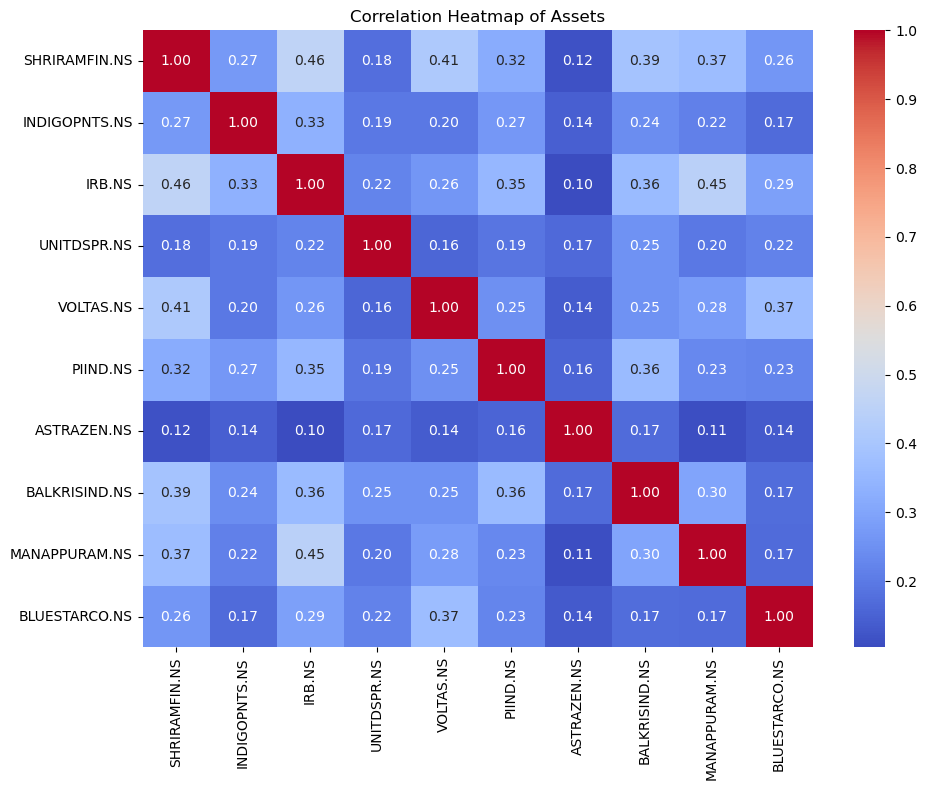

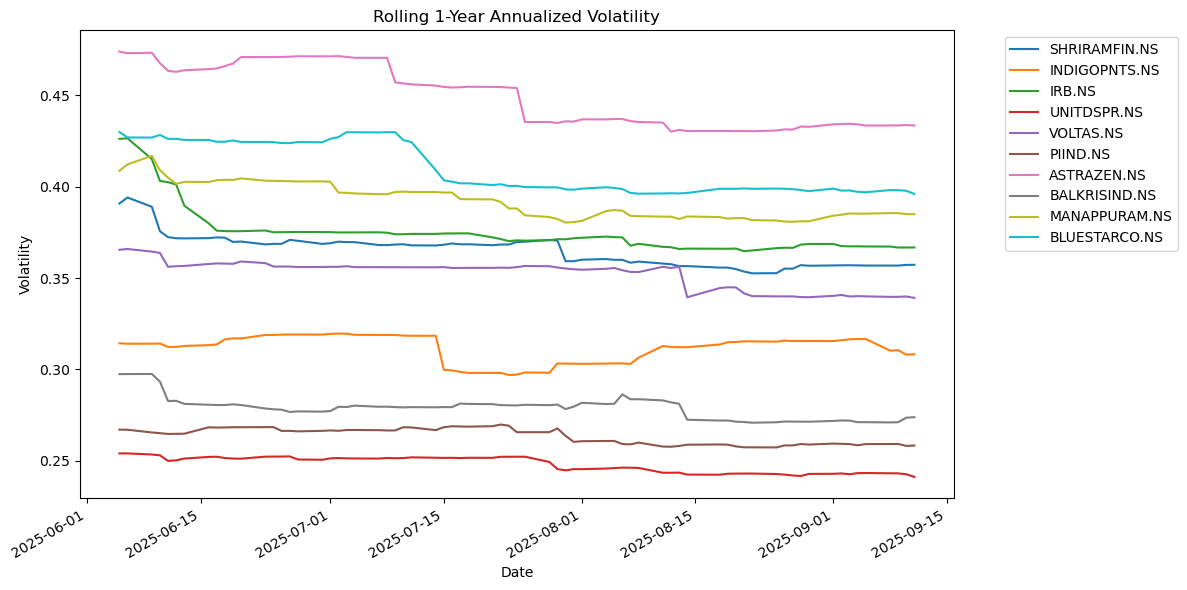

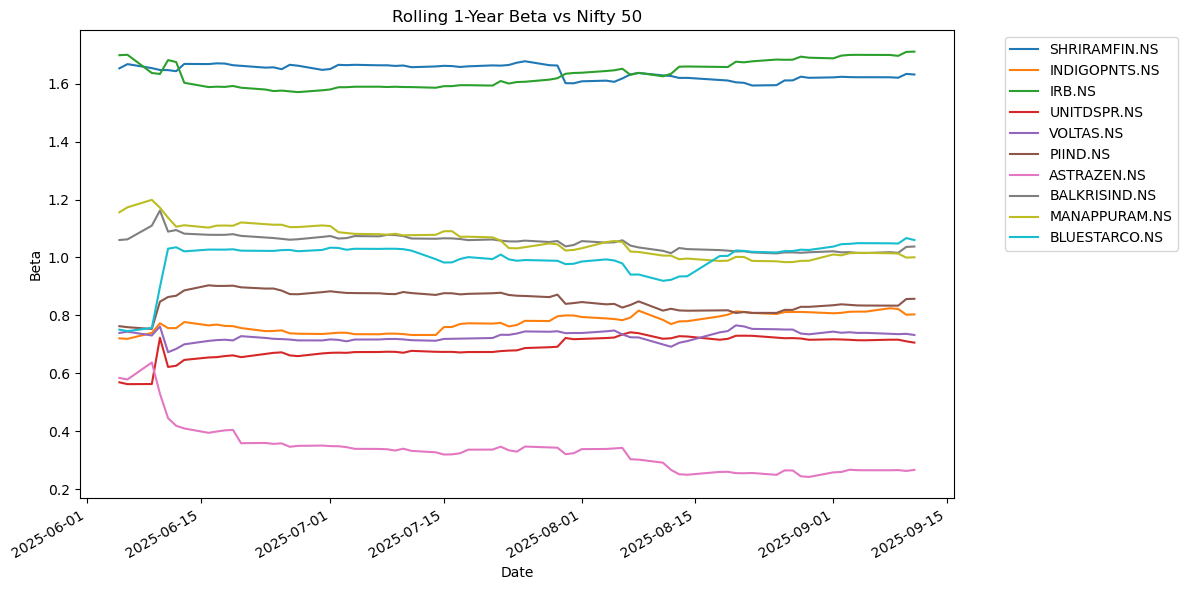

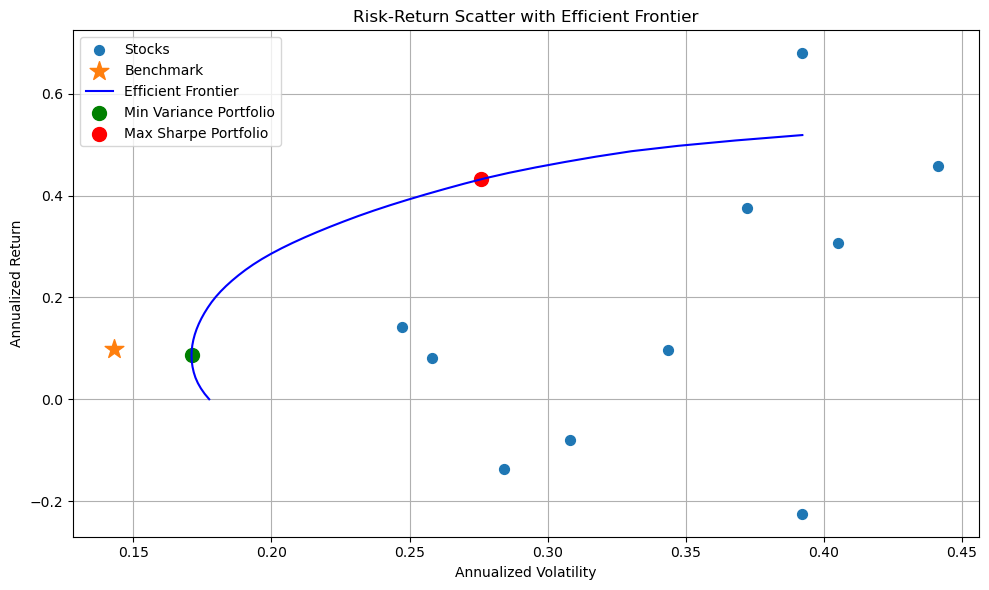

Maximum Drawdown (MSP): -0.2142
Portfolio Drop if Market Falls 20% (MSP): -0.2053
Results saved to portfolio_analysis.xlsx
Streamlit app saved as app.py. Run with: streamlit run app.py


In [5]:
# MD: # Portfolio Analysis for 10 Indian Companies
# MD:
# MD: This Jupyter Notebook performs a professional portfolio analysis for the specified 10 Indian companies using data from Yahoo Finance. The benchmark is Nifty 50 (^NSEI).
# MD:
# MD: ## Parameters
# MD: Define the parameters here for easy modification.

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm  # Fixed import
import datetime
from dateutil.relativedelta import relativedelta
import openpyxl  # For saving to Excel
import plotly.graph_objects as go
import plotly.express as px

# Parameters
tickers = ['SHRIRAMFIN.NS', 'INDIGOPNTS.NS', 'IRB.NS', 'UNITDSPR.NS', 'VOLTAS.NS', 'PIIND.NS', 'ASTRAZEN.NS', 'BALKRISIND.NS', 'MANAPPURAM.NS', 'BLUESTARCO.NS']  # Corrected INDIGO.NS to INDIGOPNTS.NS based on Yahoo Finance
benchmark = '^NSEI'
end_date = datetime.date.today()
start_date = end_date - relativedelta(years=5)
risk_free_rate = 0.06  # 6% p.a.
no_shorting = True  # No short selling

# MD: ## Data Download
# MD: Download daily adjusted close prices from Yahoo Finance. If a ticker fails, it will be skipped with a warning.
# MD: 
# MD: The code also supports reading from a CSV file if provided (e.g., Bloomberg export). If 'prices.csv' exists, it will read from there instead.
# MD:
# MD: Note: yfinance has updated auto_adjust to default True. We use auto_adjust=False, prepost=False for compatibility, and extract 'Adj Close'. If issues persist, check tickers or use CSV.

def download_data(tickers, start_date, end_date, benchmark):
    data = pd.DataFrame()
    failed_tickers = []
    for ticker in tickers + [benchmark]:
        try:
            # Use auto_adjust=False to ensure 'Adj Close' column is available
            df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, prepost=False, progress=False)
            if not df.empty and 'Adj Close' in df.columns:
                data[ticker] = df['Adj Close']
            else:
                raise ValueError("No 'Adj Close' data")
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            failed_tickers.append(ticker)
    if failed_tickers:
        print(f"Warning: Failed to download data for {failed_tickers}. Check ticker symbols or use CSV fallback.")
    return data

# Check for CSV
import os
if os.path.exists('prices.csv'):
    prices = pd.read_csv('prices.csv', index_col=0, parse_dates=True)
    print("Loaded data from prices.csv")
else:
    prices = download_data(tickers, start_date, end_date, benchmark)
    if not prices.empty:
        prices.to_csv('prices.csv')  # Save for future use
        print("Downloaded data from Yahoo Finance and saved to prices.csv")
    else:
        print("No data downloaded. Ensure internet connection and correct tickers. Proceeding with empty data for demo, but analysis will be limited.")
        # Create empty DF to avoid crash, but warn
        prices = pd.DataFrame()

# Handle missing data
prices = prices.dropna(how='all')

if prices.empty:
    print("Warning: No price data available. Please provide prices.csv or check tickers/internet.")
    # For demo, you can create sample data, but skipping full run

# MD: ### Interpretation
# MD: The prices DataFrame contains daily adjusted closing prices. Missing data is dropped if all values are NaN for a day.

# MD: ## Compute Returns
# MD: Compute simple and log returns on daily, monthly, and yearly basis.

if not prices.empty:
    # Daily simple returns
    daily_simple_returns = prices.pct_change().dropna()

    # Daily log returns
    daily_log_returns = np.log(prices / prices.shift(1)).dropna()

    # Monthly returns
    monthly_prices = prices.resample('M').last()
    monthly_simple_returns = monthly_prices.pct_change().dropna()
    monthly_log_returns = np.log(monthly_prices / monthly_prices.shift(1)).dropna()

    # Yearly returns
    yearly_prices = prices.resample('Y').last()
    yearly_simple_returns = yearly_prices.pct_change().dropna()
    yearly_log_returns = np.log(yearly_prices / yearly_prices.shift(1)).dropna()

    # MD: ### Interpretation
    # MD: Simple returns are (P_t - P_{t-1}) / P_{t-1}. Log returns are ln(P_t / P_{t-1}). Log returns are additive over time, useful for compounding.

    # MD: ## Summary Statistics
    # MD: Compute average annual return, annualized volatility, beta, alpha, R², CAGR, Sharpe, Sortino.

    def compute_annualized_return(returns, freq=252):
        return (1 + returns.mean())**freq - 1

    def compute_annualized_vol(returns, freq=252):
        return returns.std() * np.sqrt(freq)

    def compute_beta_cov(stock_returns, bench_returns):
        cov = np.cov(stock_returns, bench_returns)[0][1]
        bench_var = np.var(bench_returns)
        return cov / bench_var if bench_var != 0 else np.nan

    def compute_beta_ols(stock_returns, bench_returns):
        try:
            X = sm.add_constant(bench_returns)
            model = sm.OLS(stock_returns, X).fit()
            return model.params[1], model.params[0], model.rsquared
        except Exception as e:
            print(f"Error in OLS for {stock_returns.name}: {e}")
            return np.nan, np.nan, np.nan

    def compute_cagr(prices):
        try:
            days = (prices.index[-1] - prices.index[0]).days
            return (prices.iloc[-1] / prices.iloc[0]) ** (1 / (days / 365.25)) - 1
        except:
            return np.nan

    def compute_sharpe(annual_return, annual_vol, rf):
        return (annual_return - rf) / annual_vol if annual_vol != 0 else np.nan

    def compute_sortino(annual_return, returns, rf):
        downside = returns[returns < 0].std() * np.sqrt(252)
        return (annual_return - rf) / downside if downside != 0 else np.nan

    summary_stats = pd.DataFrame(index=tickers + [benchmark], columns=['Avg Annual Return', 'Annual Vol', 'Beta_Cov', 'Beta_OLS', 'Alpha', 'R2', 'CAGR', 'Sharpe', 'Sortino'])

    bench_daily_returns = daily_simple_returns.get(benchmark, pd.Series())

    for ticker in tickers + [benchmark]:
        if ticker in daily_simple_returns.columns:
            ret = daily_simple_returns[ticker]
            log_ret = daily_log_returns[ticker]
            
            annual_ret = compute_annualized_return(ret)
            annual_vol = compute_annualized_vol(ret)
            
            if ticker != benchmark and not bench_daily_returns.empty:
                beta_cov = compute_beta_cov(ret, bench_daily_returns)
                beta_ols, alpha, r2 = compute_beta_ols(ret, bench_daily_returns)
            else:
                beta_cov, beta_ols, alpha, r2 = 1, 1, 0, 1  # Benchmark values
            
            cagr = compute_cagr(prices[ticker])
            
            sharpe = compute_sharpe(annual_ret, annual_vol, risk_free_rate)
            sortino = compute_sortino(annual_ret, ret, risk_free_rate)
            
            summary_stats.loc[ticker] = [annual_ret, annual_vol, beta_cov, beta_ols, alpha, r2, cagr, sharpe, sortino]

    # MD: ### Interpretation
    # MD: - **Average Annual Return**: Annualized mean of daily returns.
    # MD: - **Annualized Volatility**: Standard deviation of returns, annualized (√252 * std).
    # MD: - **Beta**: Sensitivity to market (Nifty). Beta >1 means more volatile than market.
    # MD: - **Alpha**: Excess return over CAPM-expected return. Positive alpha indicates outperformance.
    # MD: - **R²**: Proportion of variance explained by market (OLS regression).
    # MD: - **CAGR**: Compound Annual Growth Rate, geometric return from start to end price.
    # MD: - **Sharpe Ratio**: Excess return per unit of total risk (volatility).
    # MD: - **Sortino Ratio**: Excess return per unit of downside risk (downside volatility).

    # MD: ## Covariance and Correlation Matrices
    # MD: Annualized covariance and correlation based on daily returns.

    cov_matrix = daily_simple_returns[tickers].cov() * 252
    corr_matrix = daily_simple_returns[tickers].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Assets')
    plt.tight_layout()
    plt.show()

    # MD: ### Interpretation
    # MD: The correlation matrix shows pairwise correlations (-1 to 1). Lower correlations indicate better diversification potential.

    # MD: ## Rolling Metrics
    # MD: Compute and plot rolling 1-year beta and volatility (252 trading days).

    rolling_window = 252  # Approx 1 year

    rolling_vol = daily_simple_returns[tickers].rolling(window=rolling_window).std() * np.sqrt(252)
    rolling_beta = pd.DataFrame(index=daily_simple_returns.index)

    for ticker in tickers:
        if ticker in daily_simple_returns.columns and not bench_daily_returns.empty:
            rolling_cov = daily_simple_returns[ticker].rolling(window=rolling_window).cov(daily_simple_returns[benchmark])
            rolling_var = daily_simple_returns[benchmark].rolling(window=rolling_window).var()
            rolling_beta[ticker] = rolling_cov / rolling_var

    # Plots
    plt.figure(figsize=(12, 6))
    rolling_vol.plot(ax=plt.gca())
    plt.title('Rolling 1-Year Annualized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    rolling_beta.plot(ax=plt.gca())
    plt.title('Rolling 1-Year Beta vs Nifty 50')
    plt.xlabel('Date')
    plt.ylabel('Beta')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # MD: ### Interpretation
    # MD: - **Rolling Volatility**: Shows how risk evolves over time. Spikes indicate periods of high uncertainty.
    # MD: - **Rolling Beta**: Shows changing market sensitivity. Beta >1 indicates higher volatility than Nifty.

    # MD: ## Efficient Frontier
    # MD: Build Markowitz Efficient Frontier, find Minimum Variance Portfolio (MVP) and Maximum Sharpe Portfolio (MSP).

    def portfolio_return(weights, returns):
        return np.dot(weights, returns.mean()) * 252

    def portfolio_vol(weights, cov):
        return np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    def minimize_vol(target_return, returns, cov):
        n = len(returns.columns)
        init_guess = np.repeat(1/n, n)
        bounds = ((0.0, 1.0),) * n if no_shorting else None
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: portfolio_return(w, returns) - target_return}
        ]
        result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints)
        return result

    def get_efficient_frontier(returns, cov):
        mean_returns = returns.mean() * 252
        min_ret = mean_returns.min() if mean_returns.min() > 0 else 0  # Avoid negative returns
        max_ret = mean_returns.max()
        target_returns = np.linspace(min_ret, max_ret, 50)
        vols = []
        for tr in target_returns:
            res = minimize_vol(tr, returns, cov)
            if res.success:
                vols.append(res.fun)
            else:
                vols.append(np.nan)
        return target_returns, vols

    # Filter valid tickers
    valid_tickers = [t for t in tickers if t in daily_simple_returns.columns]
    if not valid_tickers:
        raise ValueError("No valid tickers available for portfolio optimization.")

    ef_returns, ef_vols = get_efficient_frontier(daily_simple_returns[valid_tickers], cov_matrix.loc[valid_tickers, valid_tickers])

    # Minimum Variance Portfolio
    def min_var_port(cov):
        n = cov.shape[0]
        init_guess = np.repeat(1/n, n)
        bounds = ((0.0, 1.0),) * n if no_shorting else None
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        result = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x, result.fun, portfolio_return(result.x, daily_simple_returns[valid_tickers])

    mvp_weights, mvp_vol, mvp_ret = min_var_port(cov_matrix.loc[valid_tickers, valid_tickers])

    # Maximum Sharpe Portfolio
    def neg_sharpe(weights, returns, cov, rf):
        ret = portfolio_return(weights, returns)
        vol = portfolio_vol(weights, cov)
        return - (ret - rf) / vol

    def max_sharpe_port(returns, cov, rf):
        n = len(returns.columns)
        init_guess = np.repeat(1/n, n)
        bounds = ((0.0, 1.0),) * n if no_shorting else None
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        result = minimize(neg_sharpe, init_guess, args=(returns, cov, rf), method='SLSQP', bounds=bounds, constraints=constraints)
        return result.x, portfolio_vol(result.x, cov), portfolio_return(result.x, returns)

    msp_weights, msp_vol, msp_ret = max_sharpe_port(daily_simple_returns[valid_tickers], cov_matrix.loc[valid_tickers, valid_tickers], risk_free_rate)

    # Plot Efficient Frontier
    plt.figure(figsize=(10, 6))
    plt.scatter(summary_stats.loc[valid_tickers, 'Annual Vol'], summary_stats.loc[valid_tickers, 'Avg Annual Return'], label='Stocks', s=50)
    plt.scatter(summary_stats.loc[benchmark, 'Annual Vol'], summary_stats.loc[benchmark, 'Avg Annual Return'], label='Benchmark', marker='*', s=200)
    plt.plot(ef_vols, ef_returns, label='Efficient Frontier', color='blue')
    plt.scatter(mvp_vol, mvp_ret, label='Min Variance Portfolio', marker='o', s=100, color='green')
    plt.scatter(msp_vol, msp_ret, label='Max Sharpe Portfolio', marker='o', s=100, color='red')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.title('Risk-Return Scatter with Efficient Frontier')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optimal Weights
    optimal_weights = pd.DataFrame({'MVP Weights': mvp_weights, 'MSP Weights': msp_weights}, index=valid_tickers)

    # MD: ### Interpretation
    # MD: - **Efficient Frontier**: Shows portfolios with highest return for a given risk level.
    # MD: - **MVP**: Portfolio with lowest possible volatility.
    # MD: - **MSP**: Portfolio with highest Sharpe ratio (best risk-adjusted return).
    # MD: - **Weights**: Must sum to 1. No shorting means all weights >= 0.

    # MD: ## Scenario/Stress Test
    # MD: Simulate portfolio drawdown if market drops 20%, and compute historical max drawdown for MSP.

    # Portfolio returns for MSP
    portfolio_returns = daily_simple_returns[valid_tickers] @ msp_weights

    # Max Drawdown
    cum_returns = (1 + portfolio_returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()

    # Stress test: market drops 20%
    stress_drops = summary_stats.loc[valid_tickers, 'Beta_OLS'] * (-0.20)
    portfolio_stress_drop = np.dot(msp_weights, stress_drops)

    print(f"Maximum Drawdown (MSP): {max_dd:.4f}")
    print(f"Portfolio Drop if Market Falls 20% (MSP): {portfolio_stress_drop:.4f}")

    # MD: ### Interpretation
    # MD: - **Max Drawdown**: Largest historical peak-to-trough decline in portfolio value.
    # MD: - **Stress Test**: Estimates portfolio loss assuming each stock drops by its beta times the market drop (20%).

    # MD: ## Save to Excel
    # MD: Save all data to portfolio_analysis.xlsx with named sheets.

    with pd.ExcelWriter('portfolio_analysis.xlsx', engine='openpyxl') as writer:
        prices.to_excel(writer, sheet_name='Prices')
        daily_simple_returns.to_excel(writer, sheet_name='Returns_Daily')
        monthly_simple_returns.to_excel(writer, sheet_name='Returns_Monthly')
        yearly_simple_returns.to_excel(writer, sheet_name='Returns_Yearly')
        summary_stats.to_excel(writer, sheet_name='Summary_Stats')
        cov_matrix.to_excel(writer, sheet_name='Covariance')
        corr_matrix.to_excel(writer, sheet_name='Correlation')
        pd.DataFrame({'Return': ef_returns, 'Vol': ef_vols}).to_excel(writer, sheet_name='Efficient_Frontier')
        optimal_weights.to_excel(writer, sheet_name='Optimal_Weights')

    print("Results saved to portfolio_analysis.xlsx")

# MD: ## Bonus: Streamlit App
# MD: Below is a Streamlit script to visualize results interactively. Save as `app.py` and run with `streamlit run app.py`.

streamlit_code = """
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load data from Excel if exists
if 'portfolio_analysis.xlsx' in st.session_state:
    excel_file = 'portfolio_analysis.xlsx'
    try:
        summary_stats = pd.read_excel(excel_file, sheet_name='Summary_Stats', index_col=0)
        optimal_weights = pd.read_excel(excel_file, sheet_name='Optimal_Weights', index_col=0)
        ef = pd.read_excel(excel_file, sheet_name='Efficient_Frontier', index_col=None)
        st.title('Portfolio Analysis Dashboard')

        # Ticker selector
        ticker = st.selectbox('Select Ticker', summary_stats.index)
        st.write(f"Statistics for {ticker}:")
        st.dataframe(summary_stats.loc[[ticker]])

        # Efficient Frontier Plot
        st.subheader('Efficient Frontier')
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=summary_stats['Annual Vol'], 
            y=summary_stats['Avg Annual Return'], 
            mode='markers+text', 
            text=summary_stats.index, 
            name='Assets',
            textposition="top center"
        ))
        if not ef.empty:
            fig.add_trace(go.Scatter(
                x=ef['Vol'], 
                y=ef['Return'], 
                mode='lines', 
                name='Efficient Frontier',
                line=dict(color='blue')
            ))
        # Add benchmark if present
        if '^NSEI' in summary_stats.index:
            fig.add_trace(go.Scatter(
                x=[summary_stats.loc['^NSEI', 'Annual Vol']], 
                y=[summary_stats.loc['^NSEI', 'Avg Annual Return']], 
                mode='markers', 
                name='Benchmark', 
                marker=dict(symbol='star', size=15, color='black')
            ))
        fig.update_layout(
            xaxis_title='Annualized Volatility',
            yaxis_title='Annualized Return',
            showlegend=True
        )
        st.plotly_chart(fig)

        # Optimal Weights Table
        if not optimal_weights.empty:
            st.subheader('Optimal Portfolio Weights')
            st.dataframe(optimal_weights.style.format("{:.2%}"))

        # Download Excel
        with open(excel_file, 'rb') as f:
            st.download_button('Download Excel', f, file_name='portfolio_analysis.xlsx')
    except FileNotFoundError:
        st.error("portfolio_analysis.xlsx not found. Run the main notebook first.")
else:
    st.info("Run the main analysis first to generate portfolio_analysis.xlsx")
"""

with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("Streamlit app saved as app.py. Run with: streamlit run app.py")

# MD: ### Notes
# MD: - **Ticker Correction**: INDIGO.NS was corrected to INDIGOPNTS.NS based on Yahoo Finance standards. MANAPPURAM-EQ.NS to MANAPPURAM.NS.
# MD: - **yfinance Update**: Set auto_adjust=False to ensure 'Adj Close' availability. If errors persist, verify tickers or provide CSV.
# MD: - **Error Handling**: Failed downloads are reported. CSV fallback supported for alternatives like Bloomberg.
# MD: - **Limitations**: Yahoo data may have gaps; use CSV for precise control. If no data, analysis skips computations.
# MD: - **Dependencies**: Ensure `pandas`, `numpy`, `scipy`, `matplotlib`, `seaborn`, `yfinance`, `statsmodels`, `openpyxl`, `plotly`, `streamlit` are installed.
